In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from data import load_data
from color_conversion import convert_rgb_cols
from correction import apply_correction

# Does correction by scaling help?

Assume that the measured color of the white paper reference is the "whitest" color we could measure under the given lighting condition,
and the effect of ambient light is a channel-wise linear rescaling of the RGB color space $[0, 255] \times [0, 255] \times [0, 255]$ to $[0, R_0] \times [0, G_0] \times [0, B_0]$,
where $(R_0, G_0, B_0)$ is the measured RGB color of the white reference.
Then inverting the rescaling per channel would recover the true color.

In [2]:
df_daylight1 = load_data("Data/Jonas1.json")
df_daylight1["lighting_condition"] = "daylight"
# df_daylight1['session_name'] = 1
df_daylight2 = load_data("Data/Baisu1.json")
df_daylight2["lighting_condition"] = "daylight"
# df_daylight2['session_name'] = 2
df_dark1 = load_data("Data/Tai4.json")
df_dark1["lighting_condition"] = "dark"
# df_dark1['session_name'] = 1
df_dark2 = load_data("Data/Zhi3.json")
df_dark2["lighting_condition"] = "dark"
# df_dark2['session_name'] = 2

df = pd.concat([df_daylight1, df_daylight2, df_dark1, df_dark2], ignore_index=True)
df[['correction_r4_R', 'correction_r4_G', 'correction_r4_B']] = df.apply(
    apply_correction,
    axis=1,
    r=4,
    correction_type='scaling',
    color_space='rgb'
)
for prefix in ['color_r4_', 'correction_r4_', 'gt__']:
    for space in ['hsv', 'lab']:
        df = convert_rgb_cols(df, prefix=prefix, to=space)
# print(df.columns)
# df.head()

# Per-channel error
for channel in ['R', 'G', 'B', 'H', 'S', 'V', 'l', 'a', 'b']:
    df[f'error_color_r4_{channel}'] = df[f'color_r4_{channel}'] - df[f'gt__{channel}']
    df[f'error_correction_r4_{channel}'] = df[f'correction_r4_{channel}'] - df[f'gt__{channel}']
# print(df.columns)
# df.head()

# Euclidean error
df['eucl_color_r4_rgb'] = np.sqrt(
    df['error_color_r4_R']**2 +
    df['error_color_r4_G']**2 +
    df['error_color_r4_B']**2
)
df['eucl_correction_r4_rgb'] = np.sqrt(
    df['error_correction_r4_R']**2 +
    df['error_correction_r4_G']**2 +
    df['error_correction_r4_B']**2
)
df['eucl_color_r4_lab'] = np.sqrt(
    df['error_color_r4_l']**2 +
    df['error_color_r4_a']**2 +
    df['error_color_r4_b']**2
)
df['eucl_correction_r4_lab'] = np.sqrt(
    df['error_correction_r4_l']**2 +
    df['error_correction_r4_a']**2 +
    df['error_correction_r4_b']**2
)
print(df.columns)

color_labels = df[['sample_number', 'label']].drop_duplicates().set_index('sample_number')

Index(['session_name', 'sample_number', 'capture_index', 'lighting_condition',
       'reflective_surface', 'pitch', 'roll', 'white_r0_R', 'white_r0_G',
       'white_r0_B', 'white_r2_R', 'white_r2_G', 'white_r2_B', 'white_r4_R',
       'white_r4_G', 'white_r4_B', 'color_r0_R', 'color_r0_G', 'color_r0_B',
       'color_r2_R', 'color_r2_G', 'color_r2_B', 'color_r4_R', 'color_r4_G',
       'color_r4_B', 'label', 'gt__R', 'gt__G', 'gt__B', 'correction_r4_R',
       'correction_r4_G', 'correction_r4_B', 'color_r4_H', 'color_r4_S',
       'color_r4_V', 'color_r4_l', 'color_r4_a', 'color_r4_b',
       'correction_r4_H', 'correction_r4_S', 'correction_r4_V',
       'correction_r4_l', 'correction_r4_a', 'correction_r4_b', 'gt__H',
       'gt__S', 'gt__V', 'gt__l', 'gt__a', 'gt__b', 'error_color_r4_R',
       'error_correction_r4_R', 'error_color_r4_G', 'error_correction_r4_G',
       'error_color_r4_B', 'error_correction_r4_B', 'error_color_r4_H',
       'error_correction_r4_H', 'error_color_r

## How to evaluate color correction quality?

- The Euclidean distance in the RGB space does not reflect the perceived difference between two colors.
- In the HSV space, per-channel differences are better interpretable.
- The Lab color space is an industry standard for perceptual uniformity.

## How much does correction by scaling improve?

Simplified questions:

- What is the overall Euclidean error?
- What about per-channel error?
- Is there a difference among colors?
- Is there a noticable trend?

In [3]:
# Summarize Euclidean error
agg_dict = {}
cols = ['eucl_color_r4_rgb', 'eucl_correction_r4_rgb', 'eucl_color_r4_lab', 'eucl_correction_r4_lab']
for col in cols:
    agg_dict[col] = ['mean', 'std']
df_eucl_stats = df.groupby(['lighting_condition', 'sample_number']).agg(agg_dict).reset_index()
# flatten multi-level columns
df_eucl_stats.columns = ['_'.join(col).strip('_') for col in df_eucl_stats.columns.values]
# Bring back color labels
df_eucl_stats = df_eucl_stats.join(
    color_labels,
    on='sample_number',
    how='left'
)
# df_eucl_stats.head()

# Overall, how much does correction improve Euclidean error?
df_eucl_stats.groupby('lighting_condition').agg({
    'eucl_color_r4_rgb_mean': 'mean',
    'eucl_correction_r4_rgb_mean': 'mean',
    'eucl_color_r4_lab_mean': 'mean',
    'eucl_correction_r4_lab_mean': 'mean'
}).reset_index().assign(
    rgb_rel_improvement=lambda x: (
        x['eucl_color_r4_rgb_mean'] - x['eucl_correction_r4_rgb_mean']
    ) / x['eucl_color_r4_rgb_mean'] * 100,
    lab_rel_improvement=lambda x: (
        x['eucl_color_r4_lab_mean'] - x['eucl_correction_r4_lab_mean']
    ) / x['eucl_color_r4_lab_mean'] * 100,
)

,lighting_condition,eucl_color_r4_rgb_mean,eucl_correction_r4_rgb_mean,eucl_color_r4_lab_mean,eucl_correction_r4_lab_mean,rgb_rel_improvement,lab_rel_improvement
0,dark,169.806366,61.892206,48.749952,21.054709,63.551304,56.810812
1,daylight,69.108266,27.686378,20.689264,11.707361,59.937675,43.413352


40-60% relative improvement, quite good actually!

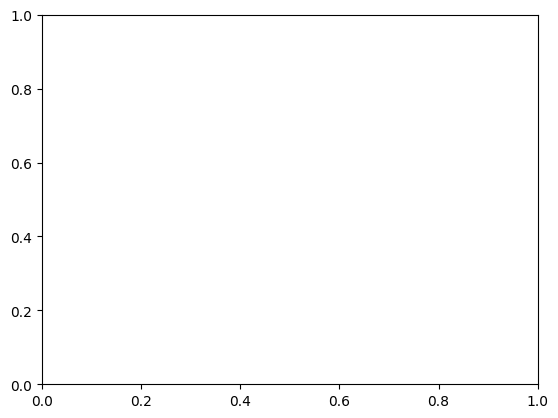

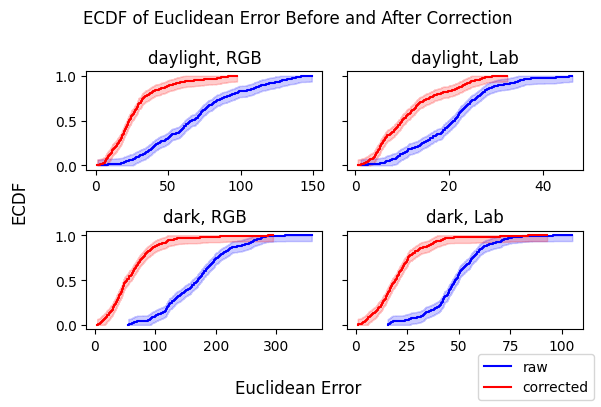

In [4]:
# What about the distribution of errors before and after correction?
# Plan: ecdf of Euclidean error with DKW confidence intervals

def ecdf(x, alpha=0.05):
    """Compute ECDF for a one-dimensional array of measurements."""
    n = len(x)
    x_sorted = np.sort(x)
    y = np.arange(1, n + 1) / n
    # DKW confidence intervals
    width = np.sqrt(np.log(2 / alpha) / (2 * n))
    lower = np.maximum(y - width, 0)
    upper = np.minimum(y + width, 1)
    return x_sorted, y, lower, upper

def plot_ecdf(eucl_raw, eucl_corrected, alpha=0.05, ax=plt.gca()):
    """Compute ECDF for a one-dimensional array of measurements."""
    x_sorted, y, lower, upper = ecdf(eucl_raw, alpha=alpha)
    ax.step(x_sorted, y, label='raw', where='post', color='blue')
    ax.fill_between(x_sorted, lower, upper, step='post', alpha=0.2, color='blue')
    x_sorted, y, lower, upper = ecdf(eucl_corrected, alpha=alpha)
    ax.step(x_sorted, y, label='corrected', where='post', color='red')
    ax.fill_between(x_sorted, lower, upper, step='post', alpha=0.2, color='red')
    return ax

# TODO: better plot theme
fig, axs = plt.subplots(2, 2, figsize=(6,4), sharey=True)

ax = axs[0, 0]
ax.set_title('daylight, RGB')
eucl_raw = df.query('lighting_condition == "daylight"')['eucl_color_r4_rgb'].values
eucl_corrected = df.query('lighting_condition == "daylight"')['eucl_correction_r4_rgb'].values
plot_ecdf(eucl_raw, eucl_corrected, ax=ax)

ax = axs[0, 1]
ax.set_title('daylight, Lab')
eucl_raw = df.query('lighting_condition == "daylight"')['eucl_color_r4_lab'].values
eucl_corrected = df.query('lighting_condition == "daylight"')['eucl_correction_r4_lab'].values
plot_ecdf(eucl_raw, eucl_corrected, ax=ax)

ax = axs[1, 0]
ax.set_title('dark, RGB')
eucl_raw = df.query('lighting_condition == "dark"')['eucl_color_r4_rgb'].values
eucl_corrected = df.query('lighting_condition == "dark"')['eucl_correction_r4_rgb'].values
plot_ecdf(eucl_raw, eucl_corrected, ax=ax)

ax = axs[1, 1]
ax.set_title('dark, Lab')
eucl_raw = df.query('lighting_condition == "dark"')['eucl_color_r4_lab'].values
eucl_corrected = df.query('lighting_condition == "dark"')['eucl_correction_r4_lab'].values
plot_ecdf(eucl_raw, eucl_corrected, ax=ax)

handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right', ncol=1)
fig.suptitle('ECDF of Euclidean Error Before and After Correction')
fig.supylabel('ECDF')
fig.supxlabel('Euclidean Error')
fig.tight_layout()
plt.show()

Observations:

- Clear separation between the ECDFs -- correction helps reduce the Euclidean error!
- Under the daylight condition, the max error can be greatly reduced by correction.
- Under the dark condition, both the max and min error can be greatly reduced by correction.

The DKW confidence interval presupposes that the observations are iid,
which might not be the case here.
The error might depend on the color.

### Visualization of raw data per-channel helps gain more insights:

In [5]:
# Cast into long format for easier plotting
value_vars = df.columns.values.tolist()
value_vars = [col for col in value_vars if col.startswith(('color', 'correction', 'error', 'gt'))]
df_long = pd.melt(
    df,
    id_vars=['lighting_condition', 'session_name', 'sample_number', 'capture_index'],
    value_vars=value_vars,
    var_name='variable',
    value_name='value'
)
# Extract channel
df_long['channel'] = df_long['variable'].str[-1]
df_long['type'] = df_long['variable'].str.split('_').str[0]
# Keep only r == 4 (used for correction)
df_long = df_long.drop(columns=['variable', 'capture_index'])
df_long['type'] = df_long['type'].map({
    'color': 'raw',
    'correction': 'corrected',
    'gt': 'true',
    'error': 'error'
})
# df_long.type.unique()
df_long = df_long.join(
    color_labels,
    on='sample_number',
    how='left'
)
df_long

,lighting_condition,session_name,sample_number,value,channel,type,label
0,daylight,Jonas 1,1,96.000000,R,raw,Dark Skin
1,daylight,Jonas 1,1,98.000000,R,raw,Dark Skin
2,daylight,Jonas 1,1,94.000000,R,raw,Dark Skin
3,daylight,Jonas 1,1,98.000000,R,raw,Dark Skin
4,daylight,Jonas 1,1,101.000000,R,raw,Dark Skin
...,...,...,...,...,...,...,...
48955,dark,Zhi_03,24,9.342313,b,error,Black
48956,dark,Zhi_03,24,9.164821,b,error,Black
48957,dark,Zhi_03,24,0.849182,b,error,Black
48958,dark,Zhi_03,24,4.072575,b,error,Black


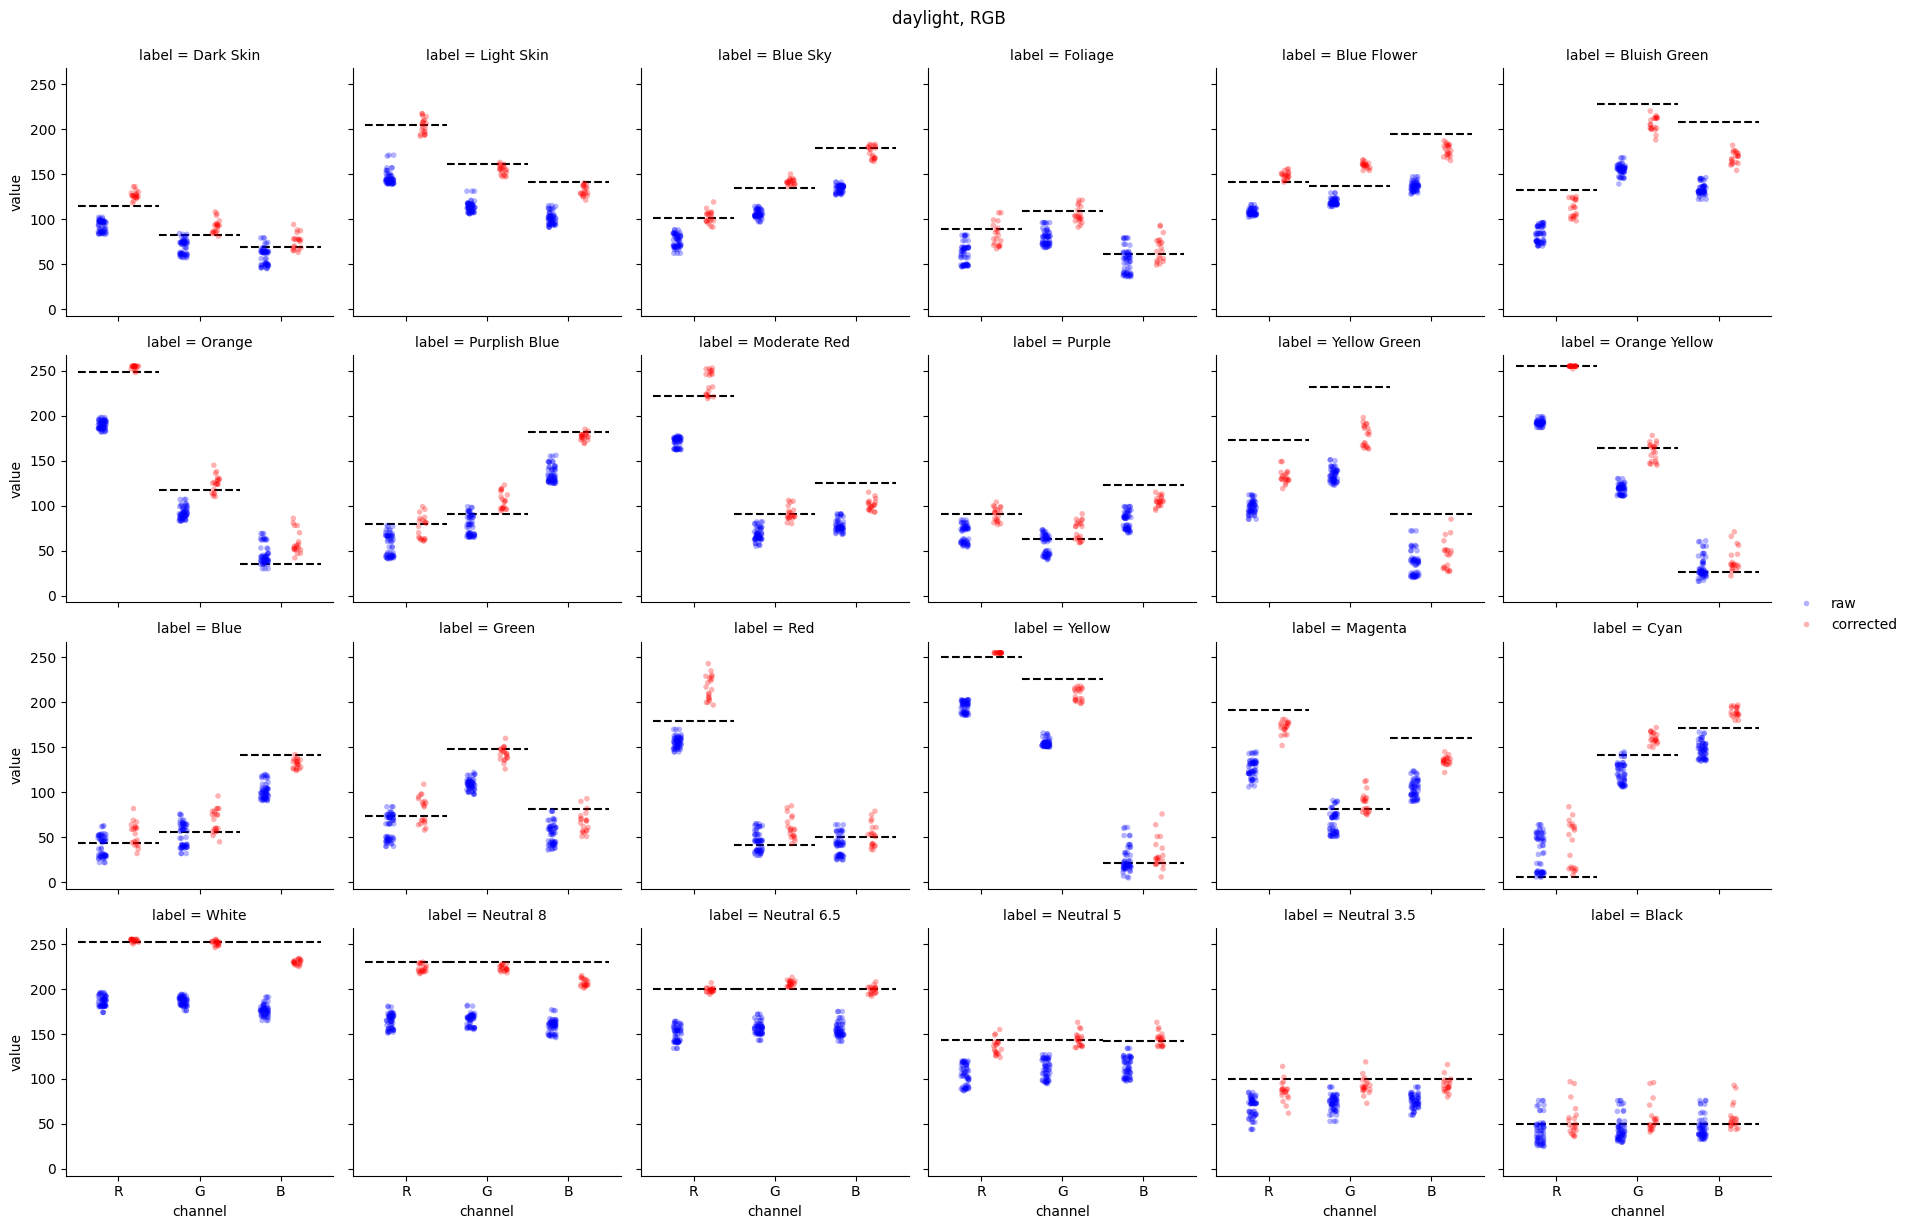

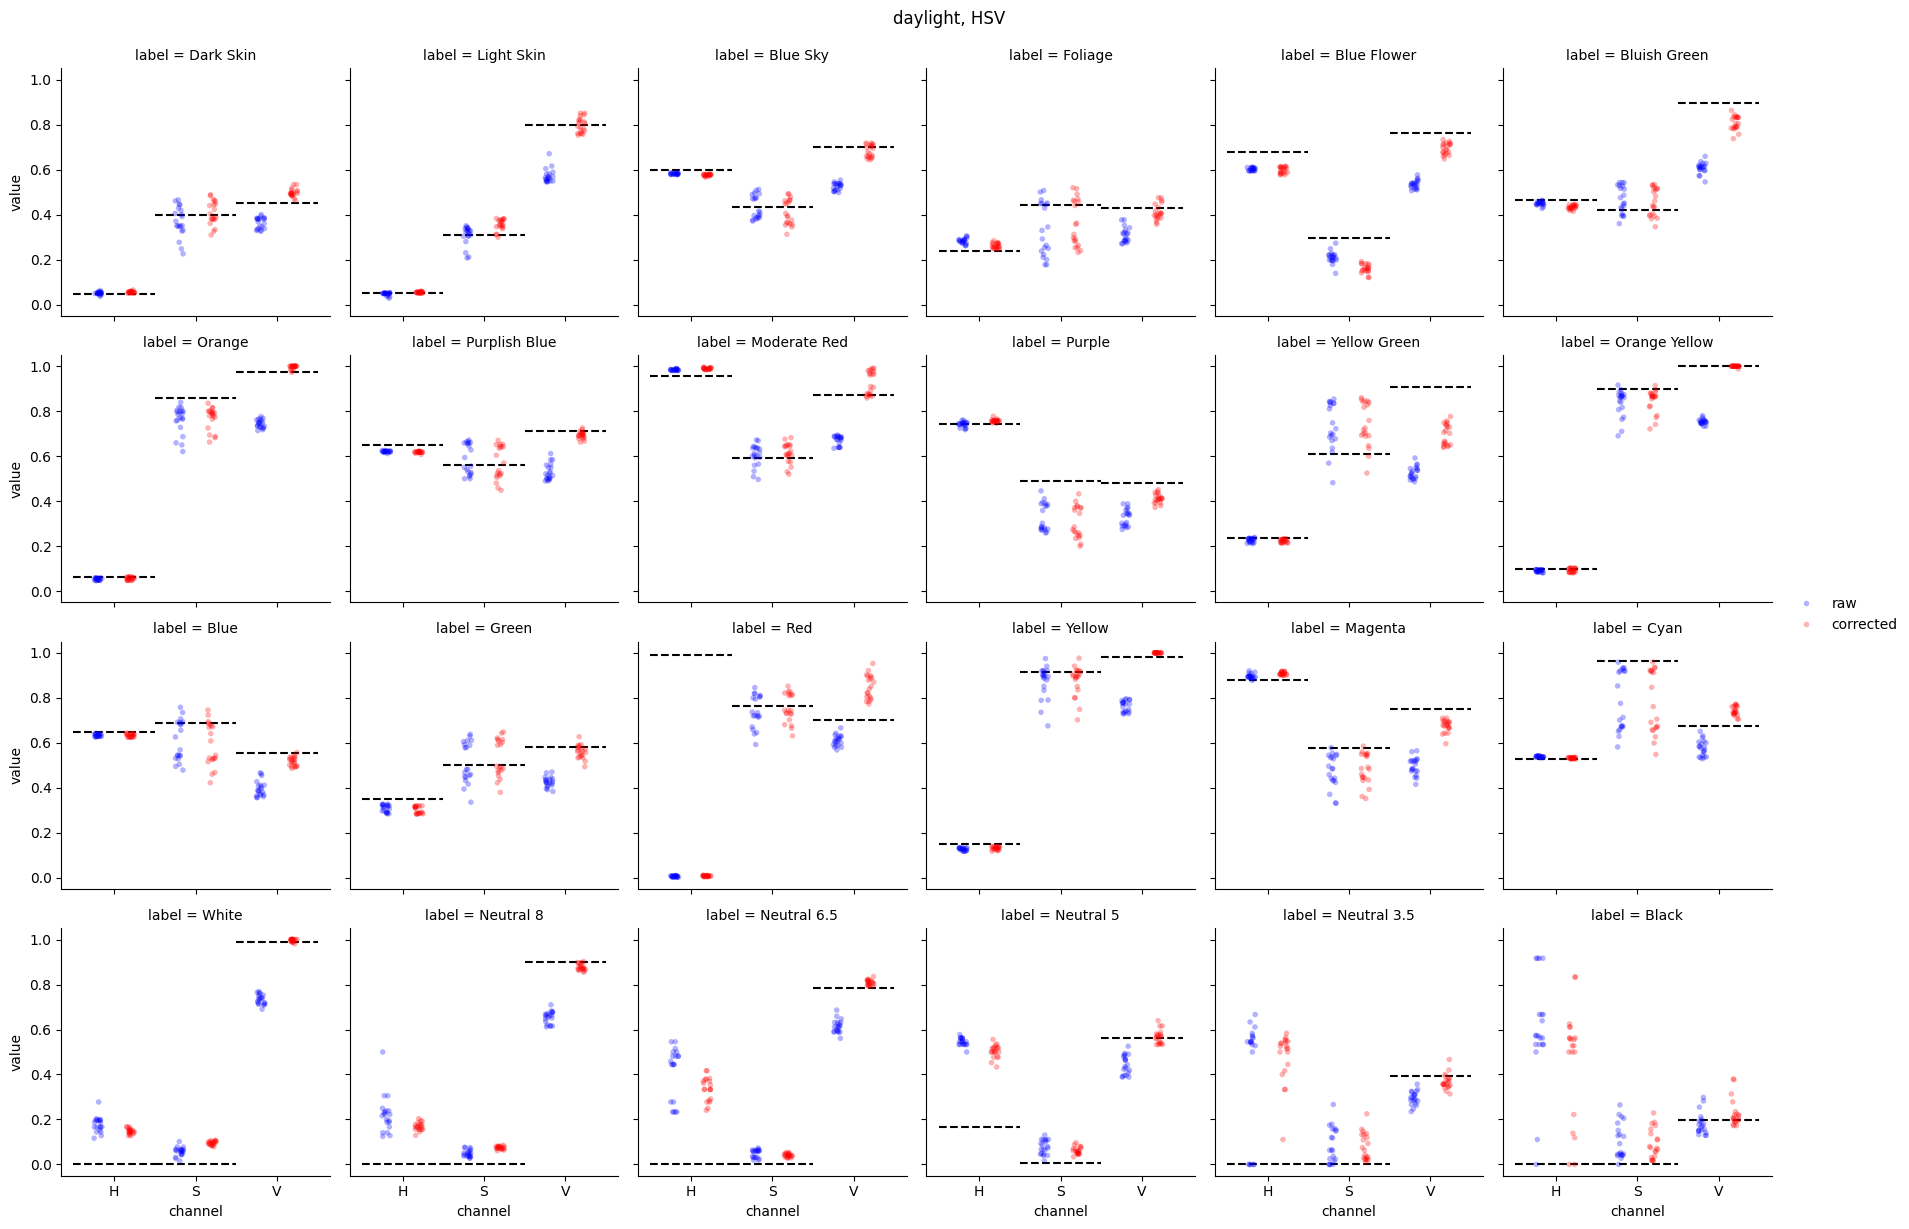

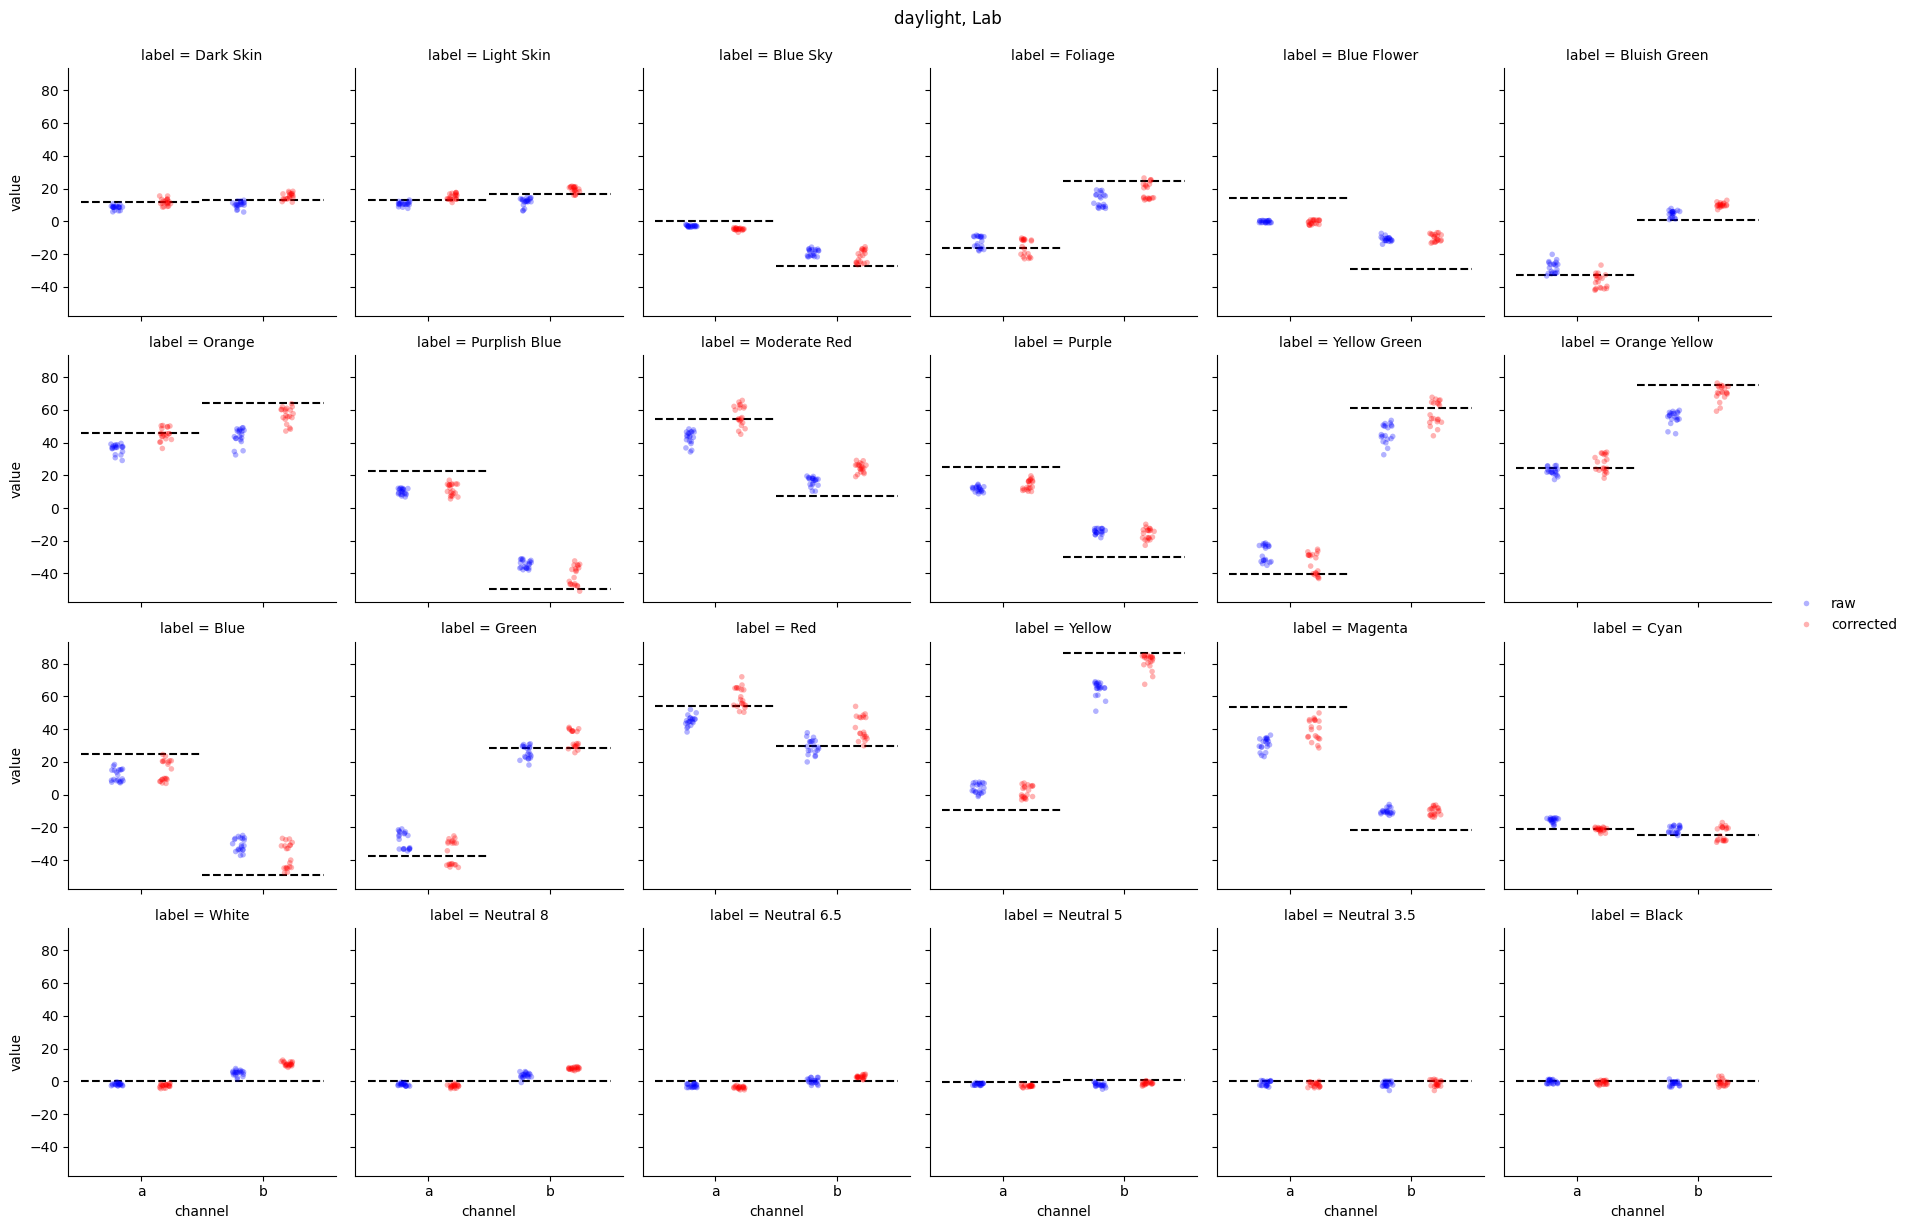

In [6]:
# This plot supersedes `plot_error_dist`
def plot_against_gt(df_long, space='rgb', lighting_condition='daylight'):
    channels = {
        'rgb': ['R', 'G', 'B'],
        'hsv': ['H', 'S', 'V'],
        'lab': ['L', 'a', 'b'],
    }[space]
    df_plot = df_long.copy().query("channel in @channels")
    g = sns.FacetGrid(df_plot.query(f"lighting_condition == '{lighting_condition}' & type in ['raw', 'corrected']"), col="label", col_wrap=6)
    # TODO: decide on which plot to use
    # g.map_dataframe(
    #     sns.violinplot,
    #     x="channel",
    #     y="value",
    #     hue="type",
    #     palette={
    #         'raw': 'blue',
    #         'corrected': 'red'
    #     },
    #     alpha=0.5,
    #     split=True,
    #     gap=0.1,
    #     inner=None
    # )
    g.map_dataframe(
        sns.stripplot,
        x="channel",
        y="value",
        hue="type",
        palette={
            'raw': 'blue',
            'corrected': 'red'
        },
        size=4,
        alpha=0.3,
        dodge=True,
    )
    # g.map_dataframe(
    #     sns.boxplot,
    #     x="channel",
    #     y="value",
    #     hue="type",
    #     palette={
    #         'raw': 'blue',
    #         'corrected': 'red'
    #     },
    #     linewidth=1,
    #     fliersize=4,
    #     gap=0.1,
    # )
    # Add hlines for ground truth
    gt_subset = df_plot.query("lighting_condition == 'daylight' & type == 'true'")
    for ax, label in zip(g.axes.flat, g.col_names):
        # break
        gt_values = gt_subset.query(f"label == '{label}'").set_index('channel')['value'].to_dict()
        for i, (ch, gt) in enumerate(gt_values.items()):
            # # Speical case: H of red is ~1, but draw at ~0 -- equivalent, but looks better
            # if label == 'Red' and ch == 'H':
            #     gt = abs(1 - gt)
            width = 0.5
            ax.hlines(
                y=gt,
                xmin=i - width,
                xmax=i + width,
                colors='black',
                linestyles='dashed',
            )
    g.add_legend()
    return g

g = plot_against_gt(df_long, space='rgb', lighting_condition='daylight')
g.figure.suptitle('daylight, RGB', y=1.02)
plt.show()

g = plot_against_gt(df_long, space='hsv', lighting_condition='daylight')
g.figure.suptitle('daylight, HSV', y=1.02)
plt.show()

g = plot_against_gt(df_long, space='lab', lighting_condition='daylight')
g.figure.suptitle('daylight, Lab', y=1.02)
plt.show()

# g = plot_against_gt(df_long, space='rgb', lighting_condition='dark')
# g.figure.suptitle('dark, RGB', y=1.02)
# plt.show()

# g = plot_against_gt(df_long, space='hsv', lighting_condition='dark')
# g.figure.suptitle('dark, HSV', y=1.02)
# plt.show()

# g = plot_against_gt(df_long, space='lab', lighting_condition='dark')
# g.figure.suptitle('dark, Lab', y=1.02)
# plt.show()

Observations (we focus on the normal daylight condition for now):

- For some colors, such as Light Skin, Blue Sky, and Yellow, correction by scaling really helps.
  This is probably due to a meaningful brightness correction, as we see from the HSV and Lab plots (`V` and `L`).
- The same pattern appears for the grayscale colors.
  Under the normal daylight, which is approximately a balanced white light, the major source of error seems to be the brightness.
- Color tone (hue and saturation) remains inaccurate after correction.
  The `a` and `b` values show the same thing.